# Healthcare Desierto Senior Capstone Project
Author: Danielle N. Cunes<br>
Date: Spring 2025

# #Step 1: Search for Healthcare Facilities

Create Google Places API and load it in

Save the info from the facility

Things to be saved

*   Name of facility
*   Address
*   Lat/Long
*   Place ID
*   Business Status

Load libraries

In [ ]:
import json
import requests
import time
import pandas as pd
from geopy.distance import geodesic
from math import radians, cos, sin, sqrt, atan2
from tqdm import tqdm
from openpyxl import load_workbook
import itertools

Load in Google Places API

In [ ]:
#Load in Google Places API using json format
with open('config.json') as config_file:
    config = json.load(config_file)

API_KEY = config['API_KEY']

if not API_KEY:
  raise ValueError("API_KEY not found in config.json")

Create helper functions to retreive the URLS

get_base_url function

In [ ]:
def get_base_url():
  return "https://places.googleapis.com/v1/places"

get_search_url

In [ ]:
def get_search_url():
  return f"{get_base_url()}:searchText"

get_facility_details_url function


In [ ]:
def get_facility_details_url(place_id):
  return f"{get_base_url()}/{place_id}"

Set up location and search_keywords

In [ ]:
location = 'Tucson, Arizona'
search_keywords = ['healthcare facility', 'healthcare', 'health', 'clinic', 'hospital', 'medical institution', 'health center', 'healthcare center', 'medical', 'clinica', 'clínica', 'medica', 'primary care']

Create filtering function to only focus on results matching hospitals, clinics, and primary care doctor offices

In [ ]:
def target_facility(name):
  name = name.lower()
  return any(
      keyword in name
      for keyword in ["hospital", "clinic", "primary care", "health center", "urgent care", "family practice", "clinica", 'health']
  )

Create search_places function to search for healthcare facilities that match the keyword search

In [ ]:
# Create search_places function
def get_business_types(place_id, api_key):
  url = "https://maps.googleapis.com/maps/api/place/details/json"
  params = {
      "place_id": place_id,
      "fields": "types",
      "key": api_key
  }
  response = requests.get(url, params=params)
  if response.ok:
    data = response.json()
    return data.get("result", {}).get("types", [])
  else:
    print(f"failed to get types for {place_id}")
    return []

In [ ]:
# Create search_places function
def search_places(location, keywords):

  # Save results of api call
  healthcare = []

  # Create a set to remove duplicates
  place_ids = set()

  for keyword in keywords:
    query = f"{keyword} in {location}"

    url = f"{get_search_url()}?key={API_KEY}"

    body = {
        "textQuery": query
    }

    params = {
        "fields": "places.displayName,places.formattedAddress,places.location,places.id,places.businessStatus"
    }

    # Send post request
    response = requests.post(url, params=params, json=body)

    # check if the reponse was succesful, if not print error message
    if not response.ok:
      print(f"Error: Request failed with status code {response.status_code} - {response.reason}")
      continue

    try:
      data = response.json()
      time.sleep(2)
    except Exception as e:
      print(f" JSON decode error: {e}")
      continue

    # Grab the name, longitude and latitude from the healthcare facility that matches the keyword and add to healthcare list
    if data.get("places"):
      for place in data["places"]:
        name = place['displayName']['text']
        lat = place['location']['latitude']
        lon = place['location']['longitude']
        dedup_key = (name.lower(), lat, lon)

        if dedup_key not in place_ids:
          place_ids.add(dedup_key)

          types = get_business_types(place['id'], API_KEY)

          entry = {
              'name': name,
              'address': place['formattedAddress'],
              'latitude': lat,
              'longitude': lon,
              'place_id': place['id'],
              'business_status': place.get('businessStatus', "UNKNOWN"),
              'matched_keyword': keyword,
              'types': types
          }

          healthcare.append(entry)
    else:
      # Print No results found for the keyword
      print(f"No results found for {query}")

    time.sleep(1)

  return healthcare

# Create results variable to hold locations found

In [ ]:
# Search for Healthcare Facilities
raw_facilities = search_places(location, search_keywords)

Save the raw_facilities results to results variable

In [ ]:
results = pd.DataFrame(raw_facilities)

Save the filtered facilities to dataframe and to an excel workbook

In [ ]:
# Save results to an Excel Workbook
results.to_excel("raw_facilities.xlsx", index=False)

Download the Excel Workbook to save

In [ ]:
#download excel workbook
from google.colab import files
files.download("raw_facilities.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Filter the Excel file to only keep the rows that are not highlighted

In [ ]:
def filter_excel_file(path="raw_facilities.xlsx", sheet_name="raw_facilities"):
  workbook = load_workbook(path, data_only=True)
  worksheet = workbook[sheet_name] if sheet_name in workbook.sheetnames else workbook.active

  data = []
  for row in worksheet.iter_rows(values_only=False):
    first_cell = row[0]
    fill = first_cell.fill.start_color

    # Get the rgb color
    color = fill.rgb if fill.type == 'rgb' else fill.index
    if not color:
      continue

    #convert tp uppercase
    color = color.upper()

    # Define the rgb hex colors to compare
    blue_rgb = 'FF00B0F0'
    orange_rgb = 'FFFFC000'
    yellow_rgb = 'FFFFFF00'

    # filter out the colors, exclude yellow, keep blue and orange
    if color == yellow_rgb:
      continue
    elif color == blue_rgb:
      category = 'primary_care'
    elif color == orange_rgb:
      category = 'hospital'
    else:
      continue

    # Extract the values of the row
    row_values = [cell.value for cell in row]

    while len(row_values) < 8:
      row_values.append(None)

    # Name the columns
    columns = ['name', 'address', 'latitude', 'longitude', 'place_id', 'business_status', 'matched_keyword', 'business_type']

    # Add the category column
    row_values.append(category)
    columns.append('category')

    # Append the formatted row
    data.append(dict(zip(columns, row_values)))

  return data

Filter out unrelated facilities

In [ ]:
approved_facilities = filter_excel_file("raw_facilities.xlsx")

In [ ]:
# saved approved facilities to xlsx
approved_facilities_df = pd.DataFrame(approved_facilities)
approved_facilities_df.to_excel("approved_facilities.xlsx", index=False)

In [ ]:
#downloadthe xlsx
from google.colab import files
files.download("approved_facilities.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Step 2: Filter by business status

Keep count of number of facilities

Operational

*Closed Temporarily

*Closed Permanently

Create function that filters through facilities found by keyword match and keeps only faicilities that are currently operational

In [ ]:
# Create operational_facilities function
def operational_facilities(places):
  operational = []
  counts = {
      "total": len(places),
      "operational": 0,
      "unknown_status": 0
  }

  for place in places:
    status = place.get("business_status", "UNKNOWN")

    if status == "OPERATIONAL":
      operational.append(place)
      counts["operational"] += 1
    else:
      counts["unknown_status"] += 1

  return operational, counts

# Save operational facilities to operational variable

In [ ]:
operational, counts = operational_facilities(approved_facilities)

#Step 3: Get Details for Operational Facilities

Phone Number

Business Hours

Create function to extract the business details for each operational Healthcare Facility

In [ ]:
# Create get_facility_details function
def get_facility_details(place_id):
  # Set up url
  url = f"{get_facility_details_url(place_id)}?key={API_KEY}"

  # set up params
  params = {
      "fields": "displayName,formattedAddress,internationalPhoneNumber,regularOpeningHours.weekdayDescriptions"
      }

  # Create response
  response = requests.get(url, params=params)

  # Print Error Message if it fails
  if not response.ok:
    print(f"Failed to get details for Place ID: {place_id}")
    print("Status code:", response.status_code)
    print("Response:", response.text)
    return {}

  try:
    return response.json()
  except Exception as e:
    print(f"JSON error on details request: {e}")
    return {}

  time.sleep(1)

  return data

Use for loop to add facility details

In [ ]:
def add_facility_details(places, delay=0.25):
  # Create facility details list to add details of facility
  facility_details = []
  total = len(places)

  estimated_total = round(total * delay, 2)
  print(f"Estimated time to update facility profile: ~{estimated_total} seconds ({round(estimated_total / 60, 2)} minutes)\n")

  count = 0
  for place in places:
    count += 1
    print(f"Updating profile details {count}/{total}: {place['name']}")

    details = get_facility_details(place["place_id"])
    place["phone"] = details.get("internationalPhoneNumber", "N/A")
    # Format hours while looping through
    hours = details.get("regularOpeningHours", {}).get("weekdayDescriptions", [])
    place["business_hours"] = "\n".join(hours) if hours else "N/A"

    facility_details.append(place)

    time.sleep(delay)

  print("Facility profile completed!")

  return facility_details

Add facility details to the operational facilities

In [ ]:
operational_with_details = add_facility_details(operational, delay=0.25)

Estimated time to update facility profile: ~13.0 seconds (0.22 minutes)

Updating profile details 1/52: Northwest Medical Center
Updating profile details 2/52: Tucson Medical Center
Updating profile details 3/52: MHC Healthcare Clinica Del Alma Health Center
Updating profile details 4/52: MHC Healthcare Wilmot Family Health Center
Updating profile details 5/52: MHC Healthcare Primary Care Health Center
Updating profile details 6/52: Northwest Medical Center Houghton
Updating profile details 7/52: Barrio Healthcare
Updating profile details 8/52: HealthOn Broadway
Updating profile details 9/52: UA Campus Health Service
Updating profile details 10/52: MHC Healthcare Flowing Wells Family Health Center
Updating profile details 11/52: HealthOn University
Updating profile details 12/52: Pinnacle HealthCare
Updating profile details 13/52: Community Partners Integrated Healthcare
Updating profile details 14/52: ArchWell Health
Updating profile details 15/52: Optima Medical - Tucson
Updating pro

Create dataframe to hold the results

In [ ]:
operational_df = pd.DataFrame(operational_with_details)

In [ ]:
# Convert the latitude and longitude columns to be numeric
operational_df['latitude'] = pd.to_numeric(operational_df['latitude'])
operational_df['longitude'] = pd.to_numeric(operational_df['longitude'])

#Remove rows with NaNs
operational_df = operational_df.dropna(subset=['latitude', 'longitude'])

Convert to a list of dictionaries to easily pass dataframe to other functions

In [ ]:
operational_list = operational_df.to_dict(orient='records')

#Step 3: Clean the bus stop data

Check for duplicates

Check for na values

Create new df

Keep only the relevant columns and add to new df

Clean up the latitude and longitude coordinates

Load in the bus_stop.csv file

In [ ]:
# load in bus_stop.csv
bus_stops = pd.read_csv('bus_stops.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'bus_stops.csv'

Check for duplicates

In [ ]:
bus_stops.duplicated().sum()

np.int64(0)

Check for na values

In [ ]:
# Check bus_stops data frame for na values
bus_stops.isna().sum()

,0
X,1
Y,1
OBJECTID,0
StopId,2
StopAbbr,2
StopName,2
NodeAbbr,2
OnStreet,2
AtStreet,2
Lon,2


Drop the Telephone and UA columns then drop the rows with na values

In [ ]:
# drop the telephone column
bus_stops.drop(columns=['Telephone', 'UA'], inplace=True)

#drop the rows with the na values
bus_stops.dropna(inplace=True)

Drop unnecessary columns and add to newly created data frame

In [ ]:
# Create new bus dataframe using OBJECTID, Long, Lat, GeoStatus, InService, URL
bus = pd.DataFrame()

Clean up Latitude and Longitude coordinates

In [ ]:
# Create function to get latitude and logitude in correct format gor Google Maps
def convert_microdegrees(value):
  try:
    return float(value) / 1_000_000
  except:
    return None

Convert the Latitude and Longitude coordinates using convert_microdegrees function

In [ ]:
# Convert the Longitude and Latitude column values
bus_stops.loc[:, 'Latitude'] = bus_stops['Lat'].apply(convert_microdegrees)
bus_stops.loc[:, 'Longitude'] = bus_stops['Lon'].apply(convert_microdegrees)

In [ ]:
bus = bus_stops[['OBJECTID', 'StopName', 'Longitude', 'Latitude','GeoStatus', 'InService', 'URL']].copy()

Function to process bus stop data

In [ ]:
def process_bus_data_from_csv(filepath):
  try:
    bus_stops = pd.read_csv(filepath)
    bus_stops.drop(columns=['Telephone', 'UA'], inplace=True, errors='ignore')
    bus_stops.dropna(inplace=True)
    bus_stops['Latitude'] = bus_stops['Lat'].apply(convert_microdegrees)
    bus_stops['Longitude'] = bus_stops['Lon'].apply(convert_microdegrees)
    bus  = bus_stops[['OBJECTID', 'StopName', 'Longitude', 'Latitude','GeoStatus', 'InService', 'URL']].copy()
    return bus
  except Exception as e:
    print(f"Error reading CSV file: {e}")
    return None

In [ ]:
bus_data = process_bus_data_from_csv('bus_stops.csv')

Error reading CSV file: name 'convert_microdegrees' is not defined


AttributeError: 'NoneType' object has no attribute 'head'

#Step 4:  Check for nearby Public Transport




Calculate the distance to each bus stop using lat/long

Determine radius (how many feet is considered reasonable for someone to walk from the bus stop to the healthcare facility)

If the facility is considered to be in the determined radius, consider it to be nearby

Create function to convert the latitude and longitude columns to folats to avoid errors

In [ ]:
def convert_lat_lon_to_float(data):
  for entry in data:
    try:
      entry['latitude'] = float(entry['latitude'])
      entry['longitude'] = float(entry['longitude'])
    except Exception as e:
      print(f"Skipping bad coordinates for {entry.get('name')}: {e}")
  return data

Create helper function for the Distance Matrix API base url

In [ ]:
# Create get distance function base url
def get_distance_matrix_base_url():
  return "https://maps.googleapis.com/maps/api/distancematrix/json"

Create get the walking distance function

In [ ]:
# Create walking distance function
def get_walking_distance(lat1, lon1, lat2, lon2, API_KEY, mode='walking'):
  if not API_KEY:
    return "No API key is provided"

  # Round coordinates to the 6th decimal place
  lat1 = round((lat1), 6)
  lon1 = round((lon1), 6)
  lat2 = round((lat2), 6)
  lon2 = round((lon2), 6)

  # Set up url
  url = get_distance_matrix_base_url()

  # Set up params
  params = {
      'origins': f"{lat1},{lon1}",
      'destinations': f"{lat2},{lon2}",
      'mode': mode,
      'key': API_KEY
  }

  # check response status
  try:
    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()

    data = response.json()
    element = data['rows'][0]['elements'][0]

    if element['status'] == 'OK':
      return element['distance']['value']
    else:
      print(f"Distance matrix error: {element['status']}")
  except requests.exceptions.Timeout:
    print("Request timed out")
    return None
  except requests.exceptions.RequestException as e:
    print(f"Request error: {e}")
    return None

Create function to convert meters to feet

In [ ]:
# Create function to convert m to ft
def convert_meters_to_feet(meters):
  try:
    feet = float(meters) * 3.28084
    return round(feet,2)
  except (TypeError, ValueError):
    return None

Create function to display the distance in meters

In [ ]:
# function to display the converted distance in feet from meters
def display_distance(meters):
  feet = convert_meters_to_feet(meters)
  if feet is not None:
    return f"The distance of the Healthcare facility from the bus stop is", {feet}, "feet"
  else:
    return "Invalid distance"

Create function to calculate the closest distance to the bus stop coordinates

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
  earth_radius_inches = 6_371_000
  phi1, phi2 = radians(lat1), radians(lat2)
  delta_phi = radians(lat2 - lat1)
  delta_lambda = radians(lon2 - lon1)

  angle = sin(delta_phi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2) ** 2
  angular_distance = 2 * atan2(sqrt(angle), sqrt(1 - angle))

  return earth_radius_inches * angular_distance

In [ ]:
def find_closest_bus(facility_lat, facility_lon, bus, top_n=3, delay=0.25):
  bus['straight_line_meters'] = bus.apply(
      lambda row: haversine_distance(facility_lat, facility_lon, row['Latitude'], row['Longitude']), axis=1
  )

  closest_stops = bus.nsmallest(top_n, 'straight_line_meters')
  min_distance = float("inf")
  closest_stop = None

  for _, row in closest_stops.iterrows():
    time.sleep(delay)
    distance_meters = get_walking_distance(facility_lat, facility_lon, row['Latitude'], row['Longitude'], API_KEY)

    if isinstance(distance_meters, (int, float)) and distance_meters < min_distance:
      min_distance = distance_meters
      closest_stop = row

  return min_distance, closest_stop

In [ ]:
# Create function to find the closest matching route to the healthcare facility
def facility_to_bus_route(results, bus, API_KEY, delay=0.25, distance_threshold_feet=1312):
  outcomes = []
  processed_names = set()

  for facility in tqdm(results, desc="Matching to bus stops"):
    facility_name = facility.get('name', 'Unknown')
    if facility_name in processed_names:
      continue
    processed_names.add(facility_name)

    facility_lat = facility['latitude']
    facility_lon = facility['longitude']
    facility_name = facility.get('name', 'Unknown Facility')
    business_status = facility.get('business_status', 'Unknown')

    time.sleep(delay)
    min_distance, closest_stop = find_closest_bus(facility_lat, facility_lon, bus)

    if closest_stop is not None and isinstance(min_distance, (int, float)):
      distance_feet = convert_meters_to_feet(min_distance)
      outcomes.append({
          "facility_name": facility_name,
          "facility_lat": facility_lat,
          "facility_lon": facility_lon,
          "business_status": business_status,
          "bus_stop_name": closest_stop['StopName'] if 'StopName' in closest_stop else closest_stop.get('OBJECT_ID', 'unknown'),
          "bus_stop_lat": closest_stop['Latitude'],
          "bus_stop_lon": closest_stop['Longitude'],
          "distance_meters": round(min_distance, 2),
          "distance_feet": round(distance_feet, 2)
      })
    else:
      print(f"No valid bus stop found for {facility['name']}")

  return pd.DataFrame(outcomes)

Hold the results in a variable to access easier later

In [ ]:
matched_df = facility_to_bus_route(operational_list, bus, API_KEY)
matched_df['nearby'] = matched_df['distance_feet'] <= 1312

Matching to bus stops: 100%|██████████| 52/52 [01:05<00:00,  1.25s/it]


In [ ]:
facilities = matched_df[['facility_name', 'facility_lat', 'facility_lon']].drop_duplicates().to_dict('records')

Merge dataframes

In [ ]:
matched_df['facility_name'] = matched_df['facility_name'].str.strip()
operational_with_details_df = pd.DataFrame(operational_with_details)

# Merge business types into proximity results
enriched_matched_df = matched_df.merge(operational_with_details_df, left_on='facility_name', right_on='name', how='left', suffixes=('', '_facility'))

In [ ]:
# save enriched_matched_df to csv to export
enriched_matched_df.to_csv('enriched_matched_df.csv', index=False)

Download the enriched_mathced_df csv

In [ ]:
from google.colab import files
files.download('enriched_matched_df.csv')

In [ ]:
# find the farthest bus stop from facility using enriched_matched_df
farthest = enriched_matched_df.loc[enriched_matched_df['distance_feet'].idxmax()]
print(farthest)

facility_name                       Carondelet St. Raphael’s Emergency Center
facility_lat                                                        32.116602
facility_lon                                                      -110.857135
business_status                                                   OPERATIONAL
bus_stop_name                                              Craycroft/I-10 TTT
bus_stop_lat                                                        32.126855
bus_stop_lon                                                      -110.875169
distance_meters                                                          2268
distance_feet                                                         7440.95
nearby                                                                  False
name                                Carondelet St. Raphael’s Emergency Center
address                               7401 S Wilmot Rd, Tucson, AZ 85756, USA
latitude                                                        

In [ ]:
# Find primary care facility that is the farthest from the nearest bus stop
primary_care_facility = enriched_matched_df[enriched_matched_df['category'] == 'primary_care']
farthest_primary_care = primary_care_facility.loc[primary_care_facility['distance_feet'].idxmax()]

In [ ]:
print(farthest_primary_care)

facility_name                                              Tucson Family Care
facility_lat                                                        32.225194
facility_lon                                                      -110.850146
business_status                                                   OPERATIONAL
bus_stop_name                                                Broadway/Jessica
bus_stop_lat                                                        32.221127
bus_stop_lon                                                      -110.847606
distance_meters                                                           784
distance_feet                                                         2572.18
nearby                                                                  False
name                                                       Tucson Family Care
address                           6624 E Carondelet Dr, Tucson, AZ 85710, USA
latitude                                                        

# Step 6: Summary Statistics

Keep counts for:

Total Operational Facilities

How many operational facilities are considered to be near public transport (based on our determined radius)


In [ ]:
def summarize_nearby_facilties(df, distance_col='distance_to_facility', threshold=1312):
  df = matched_df.copy()

  df['distance_column'] = pd.to_numeric(df[distance_col], errors='coerce')

  # Add nearby flag
  df['nearby'] = df['distance_column'] <= threshold

  # count specific facilities
  total_operational = df['facility_name'].nunique()
  nearby_facilities = df[df['nearby']]['facility_name'].nunique()

  # Create Summary df
  summary_df = pd.DataFrame({
      'total_operational': [total_operational],
      'nearby_facilities': [nearby_facilities],
      'percent_nearby': [round((nearby_facilities / total_operational) * 100, 2) if total_operational else 0]
  })

  return summary_df

In [ ]:
summary_df = summarize_nearby_facilties(enriched_matched_df, distance_col='distance_feet', threshold=1312)
print(summary_df)

   total_operational  nearby_facilities  percent_nearby
0                 50                 45            90.0


# Calculate statistics for

    - Average distance to nearest bus stop
    - Max distance to nearest bus stop
    - Facility type breakdown
    - Facilities with zero nearby stops
    - Number of stops that serve at least 1 facility
    - Stop with the highest number of facilities nearby
    - Average number of facilities per stop
    - Stops with 0 facilities within the threshold
    - Proximity overlap

In [ ]:
# Farthest stop
farthest = matched_df.loc[matched_df['distance_feet'].idxmax()]

# Count how many facilities are served by each bus stop
bus_stop_counts = matched_df[matched_df['nearby']].groupby('bus_stop_name')['facility_name'].nunique()

# Count how many bus stops serve at least one facility
num_stops_serving_facilities = (bus_stop_counts > 0).sum()

# Count how many bus stops have no facilities nearby
stops_with_no_facilities = (bus_stop_counts == 0).sum()

# Find the top bus stop that serves the most faciltities
top_stop = bus_stop_counts.sort_values(ascending=False).head(1)

facilities_per_stop = matched_df[matched_df['nearby']].groupby('bus_stop_name')['facility_name'].nunique()

avg_fac_per_stop = round(facilities_per_stop.mean(), 2)

# Step 7 Visualizations

    - Create different visualizations for the summary statistics

    - Pie Chart: Percentage of Healthcare Facilities Accessible by Bus

    - Horizontal Bar Chart: Healthcare Facility Distance to Nearest Bus Stop

<Axes: title={'center': 'Percentage of Healthcare Facilities Accessible by Bus'}, ylabel='count'>

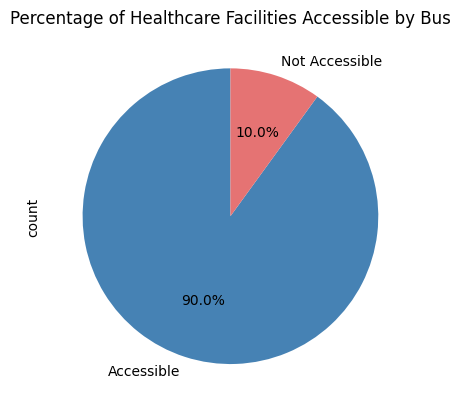

In [ ]:
# pie chart showing if healthcare facilities are accessible by bus
matched_df['nearby'].value_counts().plot.pie(
    labels=['Accessible', 'Not Accessible'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4682B4', '#E57373'],
    title='Percentage of Healthcare Facilities Accessible by Bus',
    textprops={'color':'black'}
)

In [ ]:
# print facilities that are less than 1312 feet away and more than 801 feet
print(matched_df[(matched_df['distance_feet'] < 1312) & (matched_df['distance_feet'] > 801)])

# print how many there are
print(len(matched_df[(matched_df['distance_feet'] < 1312) & (matched_df['distance_feet'] > 801)]))

                                       facility_name  facility_lat  \
0                           Northwest Medical Center     32.319515   
15         Banner - University Medical Center Tucson     32.242930   
17                    Tucson Clinica Medica Familiar     32.178562   
23                             St. Joseph's Hospital     32.226508   
30   Carondelet St. Joseph's Hospital Emergency Room     32.227317   
31                                        TMC Rincon     32.146989   
43                 Northwest Primary Care at Gateway     32.322046   
44     Milagros Family Healthcare (Lisnet Jorge FNP)     32.153573   
45  Banner - University Medicine Primary Care Clinic     32.100921   

    facility_lon business_status           bus_stop_name  bus_stop_lat  \
0    -111.009089     OPERATIONAL  La Cholla/Hospital Dr.     32.319062   
15   -110.946201     OPERATIONAL      Campbell Av/Lester     32.243951   
17   -110.983127     OPERATIONAL             Ajo/16th Av     32.177962   
23 

<Axes: title={'center': 'Healthcare Facility Distance to Nearest Bus Stop'}, ylabel='distance_range'>

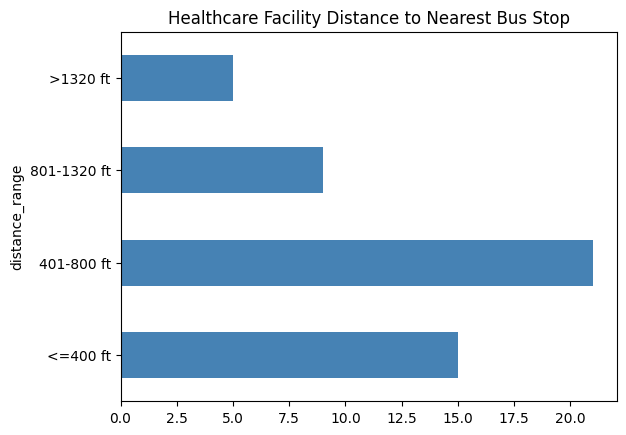

In [ ]:
# horizontal bar chart to show how far facilities are from the nearest stop
bins = [0,400,800,1320, matched_df['distance_feet'].max()]
labels=['<=400 ft', '401-800 ft', '801-1320 ft', '>1320 ft']
matched_df['distance_range'] = pd.cut(matched_df['distance_feet'], bins=bins, labels=labels)

matched_df['distance_range'].value_counts().sort_index().plot(
    kind='barh',
    title='Healthcare Facility Distance to Nearest Bus Stop',
    color='#4682B4'
)

Summary Stats Table
- Table showing
- Total Operational healthcare facilities
- Healthcare facilities accessible bby bus
- Percentage accessible (<= 1320ft)
- Average distance to nearest stop
- Max distance to the nearest stop

Find summary stats before creating the table for easy insertion

In [ ]:
total_facilities = matched_df['facility_name'].nunique()
accessible_facilities = matched_df[matched_df['nearby']]['facility_name'].nunique()
percentage_accessible = (accessible_facilities / total_facilities) * 100

average_distance = round(matched_df['distance_feet'].mean(), 1)
max_distance = round(matched_df['distance_feet'].max(), 1)

facilities_no_stop = total_facilities - accessible_facilities

# Group the bus stops with how many unqiue healthcare facilities there are
stop_facility_counts = matched_df[matched_df['nearby']].groupby('bus_stop_name')['facility_name'].nunique()
num_stops_serving_facilities = (stop_facility_counts > 0).sum()
stops_with_zero = len(bus['StopName'].unique()) - num_stops_serving_facilities

average_fac_per_stop = round(stop_facility_counts.mean(), 1)
most_connected_stop = stop_facility_counts.idxmax()
most_connected_count = stop_facility_counts.max()

# clean up category and nearby column
enriched_matched_df['category'] = enriched_matched_df['category'].fillna('Unknown')
enriched_matched_df['accessible'] = enriched_matched_df['nearby'].map({True: 'Accessible', False: 'Not Accessible'})

# Group category and accessibility
stacked_data = enriched_matched_df.groupby(['category', 'accessible'])['facility_name'].nunique().reset_index()

# rename

In [ ]:
summary_data = {
    'Metric': [
        'Total Operational Healthcare Facilities',
        'Healthcare Facilities Accessible by Bus',
        'Percentage Accessible (<= 1200 ft)',
        'Average Distance to Nearest Stop',
        'Maximum Distance to Nearest Stop',
        'Healthcare Facilities With No Nearby Stop',
        'Bus Stops that serve >=1 facility',
        'Bus Stops With 0 Nearby Facilities',
        'Average Number of Facilities per Stop',
        'Most Connected Bus Stop (by count)'
        ],
    'Value': [
        total_facilities,
        accessible_facilities,
        f'{percentage_accessible}%',
        f'{average_distance} feet',
        f'{max_distance} feet',
        facilities_no_stop,
        num_stops_serving_facilities,
        stops_with_zero,
        average_fac_per_stop,
        f'{most_connected_stop} ({most_connected_count})'
        ]
}

summary_df = pd.DataFrame(summary_data)

In [ ]:
# print summary_data
print(summary_df)

                                      Metric                  Value
0    Total Operational Healthcare Facilities                     50
1    Healthcare Facilities Accessible by Bus                     45
2         Percentage Accessible (<= 1200 ft)                  90.0%
3           Average Distance to Nearest Stop             870.7 feet
4           Maximum Distance to Nearest Stop            7440.9 feet
5  Healthcare Facilities With No Nearby Stop                      5
6          Bus Stops that serve >=1 facility                     40
7         Bus Stops With 0 Nearby Facilities                   1535
8      Average Number of Facilities per Stop                    1.1
9         Most Connected Bus Stop (by count)  BUMC/South Campus (2)


In [ ]:
# print the facility that is the farthest distance to a bus stop
print(farthest)

In [ ]:
# nearest facility to bus stop
closest = enriched_matched_df.loc[enriched_matched_df['distance_feet'].idxmin()]
print(closest)

In [ ]:
# print the facilities that are flagged as not nearby
not_nearby = matched_df[~matched_df['nearby']]
print(not_nearby)

                                facility_name  facility_lat  facility_lon  \
5           Northwest Medical Center Houghton     32.195133   -110.774725   
22                         Tucson Family Care     32.225194   -110.850146   
29  Carondelet St. Raphael’s Emergency Center     32.116602   -110.857135   
34                   Tucson VA Medical Center     32.180984   -110.964507   
35         Banner - University Medicine North     32.276634   -110.941818   

   business_status       bus_stop_name  bus_stop_lat  bus_stop_lon  \
5      OPERATIONAL    22nd St/Houghton     32.206509   -110.773947   
22     OPERATIONAL    Broadway/Jessica     32.221127   -110.847606   
29     OPERATIONAL  Craycroft/I-10 TTT     32.126855   -110.875169   
34     OPERATIONAL          Ajo/2rd Av     32.177931   -110.963149   
35     OPERATIONAL   Campbell Av/Allen     32.276224   -110.943700   

    distance_meters  distance_feet  nearby distance_range  
5              1601        5252.62   False       >1320 f

In [ ]:
print(percentage_accessible)

Save summary_df to a csv

In [ ]:
# Save the summary_df to a csv and download it
summary_df.to_csv('summary_stats_table.csv', index=False)
from google.colab import files
files.download('summary_stats_table.csv')